In [43]:
import numpy as np
import torch, pickle

from astropy.table import Table

from spenderq import util as U

In [36]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [2]:
bal = Table.read('/tigress/chhahn/spender_qso/london/contamin/bal_cat.fits')
dla = Table.read('/tigress/chhahn/spender_qso/london/contamin/dla_cat_mask_20.30.fits')

In [3]:
tids_bal_dla = np.concatenate([np.array(bal['TARGETID']), np.array(dla['TARGETID'])])

In [47]:
niter, ibatch = 3, 0
with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:            
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
has_bal_dla = np.zeros(len(target_id)).astype(bool)
for i, tid in enumerate(np.array(target_id)): 
    if tid in tids_bal_dla: 
        has_bal_dla[i] = True
print('%i flagged for BAL/DLA' % (np.sum(has_bal_dla)))

21 flagged for BAL/DLA


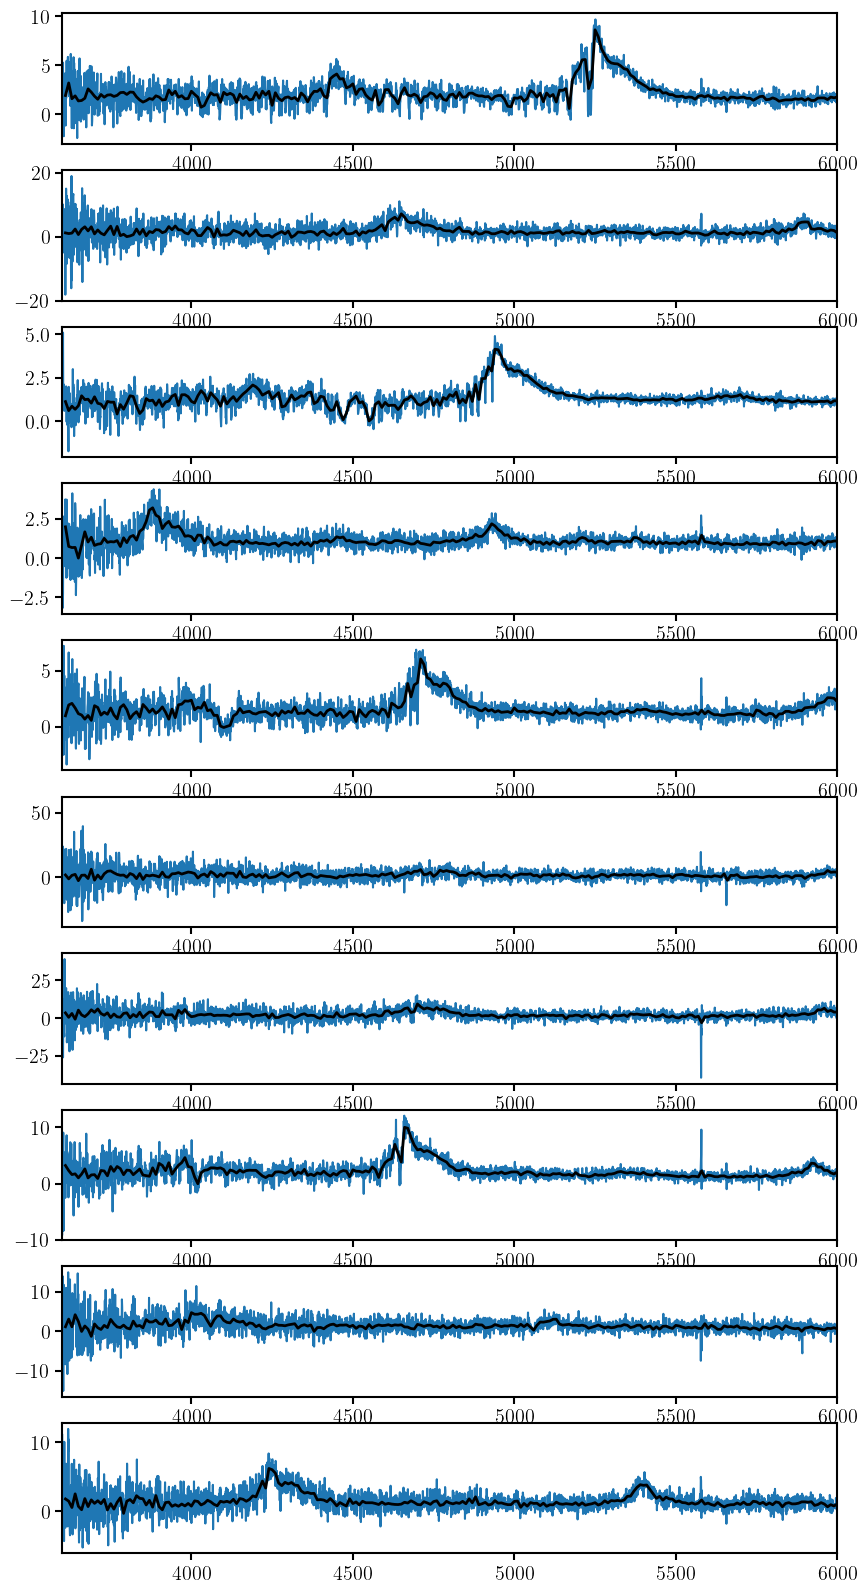

In [50]:
fig = plt.figure(figsize=(10,20))
for i in range(10): 
    sub = fig.add_subplot(10,1,i+1)

    sub.plot(np.linspace(3600., 9824., 7781), spec[has_bal_dla][i+5])

    wave_rebin = np.arange(3600, 9824, 10)[1:-1]
    spec_rebin = U.trapz_rebin(np.linspace(3600., 9824., 7781), np.array(spec[has_bal_dla][i+5]), xnew=wave_rebin)
    sub.plot(wave_rebin, spec_rebin, c='k', lw=2, label='Coarse-binned')


    sub.set_xlim(3600., 6000.)
    #sub.set_ylim()

In [33]:
niter = 3 
counter, new_batch, batch_size = 0, True, 1024

for ibatch in range(5): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:            
        spec, w, z, target_id, norm, zerr = pickle.load(f)
        
    true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))
        
    has_bal_dla = np.zeros(len(target_id)).astype(bool)
    for i, tid in enumerate(np.array(target_id)): 
        if tid in tids_bal_dla: 
            has_bal_dla[i] = True
            
    spec = spec[~has_bal_dla]
    w = w[~has_bal_dla]
    z = z[~has_bal_dla]
    target_id = target_id[~has_bal_dla]
    norm = norm[~has_bal_dla]
    zerr = zerr[~has_bal_dla]
    true_cont = true_cont[~has_bal_dla]

    if new_batch:
        batches = [spec, w, z, target_id, norm, zerr]
        __batches = true_cont
        new_batch = False
    else:
        batches[0] = torch.concatenate([batches[0], spec], axis=0)
        batches[1] = torch.concatenate([batches[1], w], axis=0)
        batches[2] = torch.concatenate([batches[2], z], axis=0)
        batches[3] = torch.concatenate([batches[3], target_id], axis=0)
        batches[4] = torch.concatenate([batches[4], norm], axis=0)
        batches[5] = torch.concatenate([batches[5], zerr], axis=0)
        __batches = np.concatenate([__batches, true_cont], axis=0)

    N = batches[0].shape[0]
    while N > batch_size:
        batch = [_batch[:batch_size] for _batch in batches]
        _batch = __batches[:batch_size]
        print(f"saving batch {counter}")
        
        filename = '/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.no_bal_dla.i%i_%i.pkl' % (niter, counter)
        #with open(filename, "wb") as f:
        #    pickle.dump(batch, f)
        np.save('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.no_bal_dla.true_cont.npy' % (counter), 
               _batch)
            
        counter += 1
        N -= batch_size

        batches = [_batch[batch_size:] for _batch in batches]   
        __batches = __batches[batch_size:]

saving batch 0
(1024, 3251)
saving batch 1
(1024, 3251)
saving batch 2
(1024, 3251)
saving batch 3
(1024, 3251)


In [6]:
batch = [_batch[:batch_size] for _batch in batches]
        
print(f"saving batch {counter}")

filename = '/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.no_bal_dla.i%i_%i.pkl' % (niter, counter)
with open(filename, "wb") as f:
    pickle.dump(batch, f)

saving batch 0
